This notebook contains the code for the travel mode prediction using the London Passenger Mode Choice data in 2019.

# Loading packages

In [1]:
# %load ModeChoiceRndFst.py
from sklearn import datasets
import numpy as np

import matplotlib.pyplot as plt
# change the font to 'Times New Roman'. By default, it is 'sans-serif'
plt.rcParams["font.family"] = "Times New Roman"

import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns

# sklearn package
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# imbalance
from imblearn.pipeline import Pipeline
from imblearn import over_sampling

import time
import rfpimp

# XGBoost
import xgboost as xgb

# hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import plotting

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base mod

# Loading data

In [2]:
# Import Dataset

print ('********************************Loading training and test set...********************************')  

lpmc_train = pd.read_csv("20200915_lpmc_train_idco_Biogeme.csv", header=0,sep=',')
lpmc_test  = pd.read_csv("20200915_lpmc_test_idco_Biogeme.csv", header=0,sep=',')

print(lpmc_train.columns)

********************************Loading training and test set...********************************
Index(['caseid', 'tripid', 'houseid', 'person_n', 'trip_n', 'travel_mode',
       'household_size_int', 'household_chld', 'household_Teen',
       'household_Avgage', 'car_ownership', 'female', 'age', 'driving_license',
       'purpose', 'fueltype', 'faretype', 'bus_scale', 'season', 'day_of_week',
       'time_of_day', 'dur1', 'dur2', 'dur3', 'dur4', 'cost3', 'cost4',
       'pt_interchange'],
      dtype='object')


The mapping from mode number to mode name is the following:

| Mode Number | Mode                  |
| ----------- | --------------------- |
| 1           | walking               |
| 2           | cycling               |
| 3           | public transport (PT) |
| 4           | driving               |

Some columns have been removed:

- 'cost1', aka the estimated cost of walking (all values being zero)
- 'cost2', aka the estimated cost of cycling (all values being zero)
- 'distance' between origin and destination (highly correlated with the driving time, 'dur4')

In [3]:
# exclude the first 6 columns
# 'caseid', 'tripid', 'houseid', 'person_n', 'trip_n', 'travel_mode'

X_train = lpmc_train.iloc[:,6:]
y_train = lpmc_train['travel_mode']

X_test = lpmc_test.iloc[:,6:]
y_test = lpmc_test['travel_mode']

# rename columns
df_feature_name_mapping = pd.DataFrame({'existing_name':['dur1', 'dur2', 'dur3', 'dur4', 'cost3', 'cost4'], 
                                        'new_name':['dur_walking', 'dur_cycling', 'dur_pt', 'dur_driving', 'cost_pt', 'cost_driving']})

dict_feature_name_mapping = dict(zip(df_feature_name_mapping['existing_name'], df_feature_name_mapping['new_name']))
X_test.columns = [dict_feature_name_mapping.get(x,x) for x in X_test.columns]
X_train.columns = X_test.columns

# create an alias for X_train2 and X_test2
X_train2 = X_train
X_test2 = X_test

list_input_features = X_train.columns.values

print ('lpmc training set size:'+ str(X_train.shape))  
print ('lpmc test set size:'+ str(X_test.shape))
print('\nlpmc features=\n')

print(list_input_features)

print ('\n********************************Loading done********************************\n') 

lpmc training set size:(54766, 22)
lpmc test set size:(26320, 22)

lpmc features=

['household_size_int' 'household_chld' 'household_Teen' 'household_Avgage'
 'car_ownership' 'female' 'age' 'driving_license' 'purpose' 'fueltype'
 'faretype' 'bus_scale' 'season' 'day_of_week' 'time_of_day' 'dur_walking'
 'dur_cycling' 'dur_pt' 'dur_driving' 'cost_pt' 'cost_driving'
 'pt_interchange']

********************************Loading done********************************



In [4]:
# the mode proportion in training and testing data
print("Mode count in training data")

y_train_no_index = y_train.reset_index()
print(y_train_no_index['travel_mode'].value_counts())

print("")
print("Mode share in training data")
print(y_train_no_index['travel_mode'].value_counts(normalize=True))
print("")

print("Mode count in testing data")
print(y_test.reset_index()['travel_mode'].value_counts())

Mode count in training data
4    24534
3    19104
1     9584
2     1544
Name: travel_mode, dtype: int64

Mode share in training data
4    0.447979
3    0.348830
1    0.174999
2    0.028193
Name: travel_mode, dtype: float64

Mode count in testing data
4    11274
3     9501
1     4684
2      861
Name: travel_mode, dtype: int64


In [5]:
X_train2.corr()

,household_size_int,household_chld,household_Teen,household_Avgage,car_ownership,female,age,driving_license,purpose,fueltype,...,season,day_of_week,time_of_day,dur_walking,dur_cycling,dur_pt,dur_driving,cost_pt,cost_driving,pt_interchange
household_size_int,1.000000,0.298623,0.207710,-0.478521,0.114494,0.004954,-0.371120,-0.181831,-0.068894,-0.221003,...,-0.013531,0.018340,-0.028490,-0.026578,-0.034637,0.003078,-0.050135,-0.048503,-0.087331,-0.011354
household_chld,0.298623,1.000000,0.082872,-0.311953,0.032410,0.025317,-0.239156,-0.127561,-0.003250,-0.026408,...,0.013726,0.009722,-0.044751,-0.060556,-0.062998,-0.054084,-0.070138,-0.077481,-0.070171,-0.044084
household_Teen,0.207710,0.082872,1.000000,-0.115573,0.031150,0.017651,-0.091538,-0.042680,-0.013759,-0.045515,...,-0.037660,-0.016250,-0.011899,-0.005484,-0.007253,0.000403,-0.008634,-0.007989,-0.022765,-0.001334
household_Avgage,-0.478521,-0.311953,-0.115573,1.000000,0.060338,-0.030179,0.828888,0.203630,0.082107,-0.063783,...,-0.007710,-0.048647,-0.025350,-0.018190,-0.020415,-0.026046,-0.035194,-0.209390,-0.035173,-0.023874
car_ownership,0.114494,0.032410,0.031150,0.060338,1.000000,-0.007462,0.064557,0.348737,0.043370,-0.738959,...,-0.000035,-0.000227,-0.007465,0.054362,0.041605,0.089080,-0.005998,-0.001434,-0.075234,0.051679
female,0.004954,0.025317,0.017651,-0.030179,-0.007462,1.000000,-0.005022,-0.092866,0.032777,0.030888,...,-0.013874,-0.023979,-0.024743,-0.093376,-0.094631,-0.083673,-0.089864,-0.040872,-0.062175,-0.072706
age,-0.371120,-0.239156,-0.091538,0.828888,0.064557,-0.005022,1.000000,0.388898,0.079700,-0.057954,...,-0.007652,-0.052642,-0.037333,-0.017356,-0.019937,-0.023694,-0.035551,-0.072593,-0.035586,-0.020616
driving_license,-0.181831,-0.127561,-0.042680,0.203630,0.348737,-0.092866,0.388898,1.000000,0.027313,-0.306965,...,0.011804,0.000446,0.028949,0.104188,0.104216,0.101251,0.092796,0.265431,0.077724,0.081932
purpose,-0.068894,-0.003250,-0.013759,0.082107,0.043370,0.032777,0.079700,0.027313,1.000000,-0.008514,...,-0.009771,0.134466,0.112072,-0.172004,-0.168252,-0.179751,-0.180168,-0.164617,-0.095128,-0.124904
fueltype,-0.221003,-0.026408,-0.045515,-0.063783,-0.738959,0.030888,-0.057954,-0.306965,-0.008514,1.000000,...,0.014046,-0.004145,0.007205,-0.062055,-0.048913,-0.085715,-0.010647,0.002479,0.061612,-0.052309


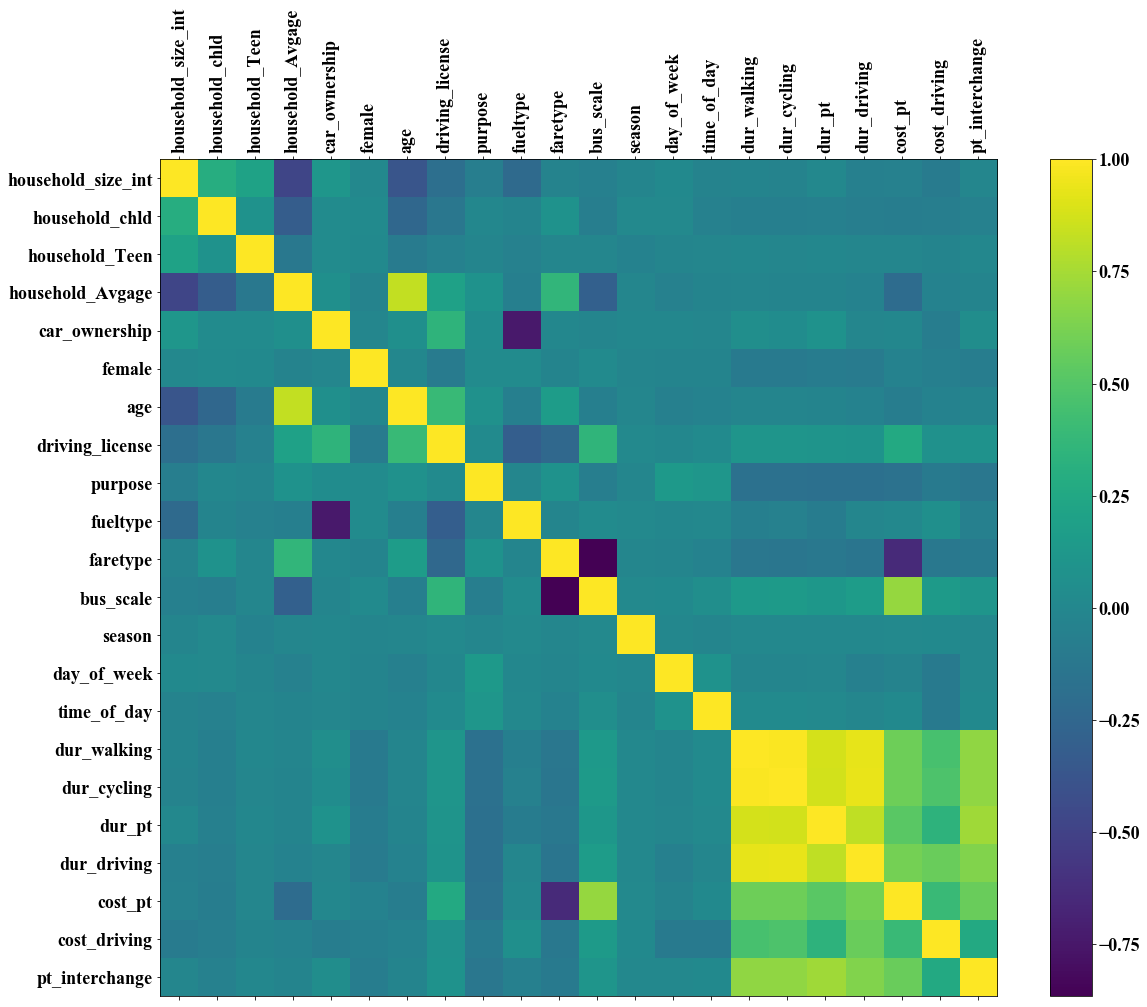

In [6]:
df = X_train2
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)

fontsize=18
# mapping the columns

plt.xticks(range(df.shape[1]), df.columns, fontsize=fontsize, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=fontsize)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize)
plt.savefig('images/feature_correlation_matrix.tif',bbox_inches='tight',dpi = 300)
# plt.title('Correlation Matrix', fontsize=16)

# Loading functions

In [19]:
def run_rf_XGBoost(X, y, random_seed=100, class_weight=None, n_est=100, resampling=None, list_categorical_data=None, random_seed_resample=None, params=None, model='RF'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_seed, stratify=y)
    if model is 'RF':
        clf = RandomForestClassifier(random_state=random_seed, class_weight=class_weight, n_estimators=n_est)
    elif model is 'XGBoost':
        clf = xgb.XGBClassifier(random_state=random_seed)

    if params is not None:
        clf.set_params(**params)
        
    #   create a oversampling object
    if resampling is 'SMOTE':
        sm = over_sampling.SMOTE(random_state=random_seed_resample)
    elif resampling is 'SMOTENC':
        sm = over_sampling.SMOTENC(random_state=random_seed_resample, categorical_features=list_categorical_data)
    elif resampling is 'ADASYN': 
        sm = over_sampling.ADASYN(random_state=random_seed_resample)
    elif resampling is 'BorderlineSMOTE':
        sm = over_sampling.BorderlineSMOTE(random_state=random_seed_resample)
    elif resampling is 'SVMSMOTE':
        sm = over_sampling.SVMSMOTE(random_state=random_seed_resample)
    elif resampling is 'KMeansSMOTE':
        sm = over_sampling.KMeansSMOTE(random_state=random_seed_resample)
    elif resampling is 'RandomOverSampler':
        sm = over_sampling.RandomOverSampler(random_state=random_seed_resample)
    
    #   resample the training data (but not the testing data)
    if resampling in ['SMOTE', 'SMOTENC', 'ADASYN', 'BorderlineSMOTE', 'SVMSMOTE', 'KMeansSMOTE', 'RandomOverSampler']:
        X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
        X_train = pd.DataFrame(X_train_smote, columns=X_train.columns)
        y_train = pd.Series(y_train_smote)
        
    clf.fit(X_train, y_train)
    print()
    print("**** Classification report:")
    print(classification_report(y_test, clf.predict(X_test)))
    
    print()
    print("**** Confusion matrix:")
    print(confusion_matrix(y_test, clf.predict(X_test)))
    
    print()
    print("**** Feature importance:")
    # feature importance
    imp = rfpimp.importances(clf, X_test, y_test) # permutation
    viz = rfpimp.plot_importances(imp)
    viz.view()
    
    return clf, X_train, X_test, y_train, y_test, imp

In [7]:
def print_result_cross_validate(scores):
    '''Reformat and print the result of RF and XGBoost.
    
    This function takes the result of the cross_validate function.
    '''
    print("Cross validation result (format: average +/- std_dev)")
    print("Training accuracy: %0.4f (+/-%0.4f)" % (scores['train_accuracy'].mean(),scores['train_accuracy'].std()))
    print("Testing accuracy: %0.4f (+/-%0.4f)" % (scores['test_accuracy'].mean(),scores['test_accuracy'].std()))
    print("Macro-average F1: %0.4f (+/-%0.4f)" % (scores['test_f1_macro'].mean(),scores['test_f1_macro'].std()))
    print("Balanced accuracy: %0.4f (+/-%0.4f)" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std()))
    print("Macro-average recall: %0.4f (+/-%0.4f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))
    print("Macro-average precision: %0.4f (+/-%0.4f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
    print("Negative log-loss: %0.4f (+/-%0.4f)" % (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std()))

# Hyperparameter tuning for RF and XGBoost

The model hyperparameters will be tuned using the Hyperopt package. Cross validation is not used here as it is shown that the RF result is very stable. This reduces the computational cost of the hyperparameter tuning process.

In [11]:
import os
os.environ['OMP_NUM_THREADS'] = "1"

from hpsklearn import HyperoptEstimator, random_forest
from hyperopt import tpe, hp

In [12]:
# settings for cv
random_seed_cv = 1001
cv_fold=10

max_evals=100

# split data into train_hp and test_hp. Only used for hyperopt
random_seed_split = 10
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_train2, y_train, random_state=random_seed_split, stratify=y_train)

## Tuning the RF

In [13]:
# Tune hyperparamters for RandomForestClassifier using hyperopt

space={'max_depth': hp.quniform("max_depth", 10, 100, 1),
       'min_samples_leaf' : hp.quniform('min_samples_leaf', 1, 11, 1),
       'n_estimators': hp.quniform("n_estimators", 100, 500, 50)
    }

# Classifier:
def hyperparameter_tuning_rf(space):
    rf_clf=RandomForestClassifier(max_depth = int(space['max_depth']), 
                          min_samples_leaf = int(space['min_samples_leaf']),
                          n_estimators = int(space['n_estimators']),
                          )
    skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
    scores_rf = cross_validate(rf_clf, X_train_hp, y_train_hp, cv=skf, return_train_score=True, scoring=['accuracy'])
    
    accuracy = scores_rf['test_accuracy'].mean()

    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK }

# the tuning process
rf_trials = Trials()
rf_best = fmin(fn=hyperparameter_tuning_rf,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=rf_trials)

print("The best model is: ")
print(rf_best)

SCORE:                                                 
0.7671763351287813                                     
SCORE:                                                                              
0.7716804425152013                                                                  
SCORE:                                                                               
0.7668353944354629                                                                   
SCORE:                                                                               
0.7663729178269035                                                                   
SCORE:                                                                               
0.7652042467215234                                                                   
SCORE:                                                                               
0.7592150540234701                                                                   
SCORE:                        

0.7784487453320843                                                                    
SCORE:                                                                                
0.7752836964178051                                                                    
SCORE:                                                                                
0.7690753360270979                                                                    
SCORE:                                                                                
0.7911087868836757                                                                    
SCORE:                                                                                
0.8059356765908253                                                                    
SCORE:                                                                                
0.7829526926858436                                                                    
SCORE:                                     

avg best error: -0.8063497166473562


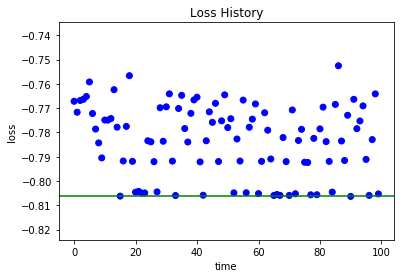

In [14]:
# plot the optimisation history

plotting.main_plot_history(rf_trials)

In [ ]:
# output the model performance: accuracy, macro-average F1 score, macro-average recall

## Tuning the XGBoost

Here, hyperparameters are tuned using the Hyperopt package. A good blog on this package can be found [here](https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9).

A list of important hyperparamters of XGBoost is as follows:

- *max_depth*: default=6. Increasing this value will make the model more complex and more likely to overfit.
- *min_child_height*: default=1. The larger min_child_weight is, the more conservative the algorithm will be.
- *gamma*: default=0. Alias is min_split_loss. Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
- *eta*: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. The larger eta, the less likely to overfit. default=0.3. Range [0,1]
- *n_estimators*: default=100.

In [15]:
# parameter space
space={'max_depth': hp.quniform("max_depth", 1, 11, 1),
       'gamma': hp.uniform ('gamma', 0,5),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 11, 1),
       'eta': hp.uniform('eta', 0.0, 1.0),
       'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    }

# Classifier:
def hyperparameter_tuning_xgb(space):
    xgb_clf=xgb.XGBClassifier(eta =space['eta'], 
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          min_child_weight=space['min_child_weight']
                          )
    skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
    scores_xgboost = cross_validate(xgb_clf, X_train_hp, y_train_hp, cv=skf, return_train_score=True, scoring=['accuracy'])
    
    accuracy = scores_xgboost['test_accuracy'].mean()
    print ("SCORE:", accuracy)
    # using accuracy as the metric
    return {'loss': -accuracy, 'status': STATUS_OK }

# the tuning process
xgb_trials = Trials()
xgb_best = fmin(fn=hyperparameter_tuning_xgb,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=xgb_trials)

print("The best XGBoost model is: ")
print(xgb_best)

SCORE:                                                 
0.7589230714701122                                     
SCORE:                                                                              
0.7589961293433753                                                                  
SCORE:                                                                              
0.7518383011027554                                                                  
SCORE:                                                                              
0.7608465870012228                                                                  
SCORE:                                                                              
0.7687833001295198                                                                  
SCORE:                                                                              
0.8006038328652082                                                                  
SCORE:                                

0.7611872965362532                                                                    
SCORE:                                                                                
0.7832936393062975                                                                   
SCORE:                                                                                
0.8038418922356657                                                                    
SCORE:                                                                                
0.7648393070562075                                                                    
SCORE:                                                                                
0.7976823240251225                                                                    
SCORE:                                                                                
0.7850951566055911                                                                    
SCORE:                                      

avg best error: -0.8078103643789584


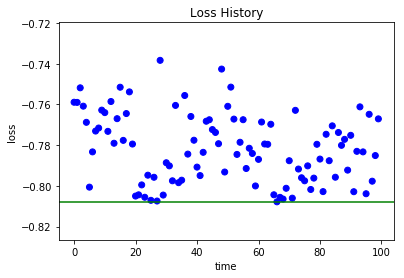

In [16]:
plotting.main_plot_history(xgb_trials)

In [17]:
# save the trials objects
# you can find out the best model and the accuracy history from the Trials objects
import joblib
joblib.dump(rf_trials, 'hyperopt_trials/RF_trials.pkl')
joblib.dump(xgb_trials, 'hyperopt_trials/XGB_trials.pkl')

['hyperopt_trials/XGB_trials.pkl']

# Random Forest Model

## Plain RF

A 10-fold standard cross-validation is used.

The metrics are accuracy, macro-average F1, and log-loss.

The code for cross-validation can be found [here](https://github.com/huanfachen/data_science_code_collection/blob/master/sklearn/cross_validation.ipynb).

In [12]:
# hyperparameters in the RF (obtained in Section 4.1)
rf_n_estimators = 450
rf_max_depth = 56
rf_min_samples_leaf = 1

cv_fold=10

# random seed for different procedures
random_seed_cv=10
random_seed_rf=1001
random_seed_resample=12

rf_params = {'max_depth':rf_max_depth, 'min_samples_leaf':rf_min_samples_leaf, 'n_estimators':rf_n_estimators, 'random_state':random_seed_rf}

rdnsta=1001

In [14]:
# Cross validation of Model 2 with default values of max_depth and max_samples
# the metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
print("Cross validation splitter: ", skf)

rf = RandomForestClassifier(criterion='gini', 
                       n_estimators=rf_n_estimators,
                       max_depth=rf_max_depth,
                       min_samples_leaf=rf_min_samples_leaf,
                       random_state= random_seed_rf,
                       n_jobs=-1)
# scores = cross_validate(rf, X_train2, y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'average_precision'])

scores = cross_validate(rf, X_train2, y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'recall_macro', 'precision_macro'])

print_result_cross_validate(scores)

Cross validation splitter:  StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
Cross validation result (format: average +/- std_dev)
Training accuracy: 1.0000 (+/-0.0000)
Testing accuracy: 0.8205 (+/-0.0046)
Macro-average F1: 0.6479 (+/-0.0063)
Balanced accuracy: 0.6355 (+/-0.0045)
Macro-average recall: 0.6355 (+/-0.0045)
Macro-average precision: 0.8219 (+/-0.0217)
Negative log-loss: -0.4998 (+/-0.0164)


## RF with SMOTE-NC

The RF with SMOTE-NC is trained using a pipeline from the imblearn package. Details can be found [here](https://github.com/huanfachen/data_science_code_collection/blob/master/sklearn/cross_validation.ipynb)

In [15]:
from imblearn.pipeline import Pipeline

# CV Splitter
skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
print("Cross validation splitter: ", skf)

# SMOTENC
list_categorical_var = ['household_size_int', 'household_chld', 'household_Teen',
       'household_Avgage', 'car_ownership', 'female', 'age_grp',
       'driving_license', 'purpose', 'fueltype', 'faretype', 'bus_scale',
       'season', 'day_of_week', 'time_of_day']
# creating a mask for categorical_var. The mask consists of TRUE and FALSE
mask_cateogrical_var = [e in list_categorical_var for e in X_train2.columns]
smtnc = over_sampling.SMOTENC(random_state=random_seed_resample, categorical_features=mask_cateogrical_var)

# RF
rf = RandomForestClassifier(criterion='gini', 
                       n_estimators=rf_n_estimators,
                       max_depth=rf_max_depth,
                       min_samples_leaf=rf_min_samples_leaf,
                       random_state= random_seed_rf,
                       n_jobs=-1)

# pipeline
ppl_smt_rf = Pipeline([('smt', smtnc), ('rf', rf)])


scores_stmnc = cross_validate(ppl_smt_rf, X_train2, y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'recall_macro', 'precision_macro'])

print_result_cross_validate(scores_stmnc)

Cross validation splitter:  StratifiedKFold(n_splits=10, random_state=10, shuffle=True)


C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in

Cross validation result (format: average +/- std_dev)
Training accuracy: 1.0000 (+/-0.0000)
Testing accuracy: 0.8124 (+/-0.0050)
Macro-average F1: 0.6989 (+/-0.0128)
Balanced accuracy: 0.6936 (+/-0.0100)
Macro-average recall: 0.6936 (+/-0.0100)
Macro-average precision: 0.7174 (+/-0.0187)
Negative log-loss: -0.5438 (+/-0.0175)


## RF with ADASYN

In [16]:
# using pipeline
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline

from imblearn.pipeline import Pipeline

# CV Splitter
skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
print("Cross validation splitter: ", skf)

# ADASYN
adasyn = over_sampling.ADASYN(random_state=random_seed_resample)

# RF
rf = RandomForestClassifier(criterion='gini', 
                       n_estimators=rf_n_estimators,
                       max_depth=rf_max_depth,
                       min_samples_leaf=rf_min_samples_leaf,
                       random_state= random_seed_rf,
                       n_jobs=-1)

# pipeline
ppl_adasyn_rf = Pipeline([('adasyn', adasyn), ('rf', rf)])

scores_adasyn = cross_validate(ppl_adasyn_rf, X_train2, y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'recall_macro', 'precision_macro'])

print_result_cross_validate(scores_adasyn)

Cross validation splitter:  StratifiedKFold(n_splits=10, random_state=10, shuffle=True)


C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in

Cross validation result (format: average +/- std_dev)
Training accuracy: 1.0000 (+/-0.0000)
Testing accuracy: 0.8211 (+/-0.0041)
Macro-average F1: 0.7155 (+/-0.0129)
Balanced accuracy: 0.6962 (+/-0.0104)
Macro-average recall: 0.6962 (+/-0.0104)
Macro-average precision: 0.7748 (+/-0.0174)
Negative log-loss: -0.5141 (+/-0.0145)


# XGBoost Model

Building XGBoost with the tuned hyperparameters in the previous sections.

## Plain XGBoost

In [13]:
# View the default hyperparameters in XGBoostClassifier
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [14]:
import xgboost as xgb
random_seed_cv = 102
random_seed_xgboost = 1003

# eta': 0.6024986478505462	gamma': 0.07829790662738734	max_depth': 11.0	min_child_weight': 4.0	n_estimators': 450.0
xgb_max_depth = 11
xgb_min_child_weight=4
xgb_n_estimators=450
xgb_eta = 0.602
xgb_gamma = 0.0783

param_dist = {'max_depth':xgb_max_depth, 'min_child_weight':xgb_min_child_weight, 'n_estimators':xgb_n_estimators, 'eta':xgb_eta, 'gamma':xgb_gamma, 'random_state':random_seed_xgboost}

In [19]:
# Cross validation of Model 2 with default values of max_depth and max_samples
# the metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
print("Cross validation splitter: ", skf)

xgb_clf = xgb.XGBClassifier(
    **param_dist
) 
scores_xgboost = cross_validate(xgb_clf, X_train2, y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'recall_macro', 'precision_macro'])

print_result_cross_validate(scores_xgboost)

Cross validation splitter:  StratifiedKFold(n_splits=10, random_state=102, shuffle=True)
Cross validation result (format: average +/- std_dev)
Training accuracy: 1.0000 (+/-0.0000)
Testing accuracy: 0.8329 (+/-0.0061)
Macro-average F1: 0.6999 (+/-0.0146)
Balanced accuracy: 0.6757 (+/-0.0116)
Macro-average recall: 0.6757 (+/-0.0116)
Macro-average precision: 0.7991 (+/-0.0151)
Negative log-loss: -0.5162 (+/-0.0259)


## XGBoost with SMOTE-NC

In [20]:
# using pipeline
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline

from imblearn.pipeline import Pipeline

# CV Splitter
skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
print("Cross validation splitter: ", skf)

# SMOTENC
list_categorical_var = ['household_size_int', 'household_chld', 'household_Teen',
       'household_Avgage', 'car_ownership', 'female', 'age_grp',
       'driving_license', 'purpose', 'fueltype', 'faretype', 'bus_scale',
       'season', 'day_of_week', 'time_of_day']
# creating a mask for categorical_var. The mask consists of TRUE and FALSE
mask_cateogrical_var = [e in list_categorical_var for e in X_train2.columns]
smtnc = over_sampling.SMOTENC(random_state=random_seed_resample, categorical_features=mask_cateogrical_var)

# XGBoost
xgb_clf = xgb.XGBClassifier(
    **param_dist
) 

# pipeline
ppl_smt_xgb = Pipeline([('smt', smtnc), ('xgb', xgb_clf)])

scores_stmnc = cross_validate(ppl_smt_rf, X_train2, y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'recall_macro', 'precision_macro'])

print_result_cross_validate(scores_stmnc)

Cross validation splitter:  StratifiedKFold(n_splits=10, random_state=102, shuffle=True)


C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in

Cross validation result (format: average +/- std_dev)
Training accuracy: 1.0000 (+/-0.0000)
Testing accuracy: 0.8114 (+/-0.0068)
Macro-average F1: 0.6995 (+/-0.0087)
Balanced accuracy: 0.6936 (+/-0.0077)
Macro-average recall: 0.6936 (+/-0.0077)
Macro-average precision: 0.7188 (+/-0.0108)
Negative log-loss: -0.5425 (+/-0.0166)


## XGBoost with ADASYN

In [15]:
# using pipeline
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline

from imblearn.pipeline import Pipeline

# CV Splitter
skf = StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=random_seed_cv)
print("Cross validation splitter: ", skf)

# ADASYN
adasyn = over_sampling.ADASYN(random_state=random_seed_resample)

# XGB
xgb_clf = xgb.XGBClassifier(
    **param_dist
) 

# pipeline
ppl_adasyn_xgb = Pipeline([('adasyn', adasyn), ('xgb', xgb_clf)])

scores_adasyn_xgb = cross_validate(ppl_adasyn_xgb, np.array(X_train2), y_train, cv=skf, return_train_score=True, scoring=['f1_macro', 'neg_log_loss', 'accuracy', 'balanced_accuracy', 'recall_macro', 'precision_macro'])

print_result_cross_validate(scores_adasyn_xgb)

Cross validation splitter:  StratifiedKFold(n_splits=10, random_state=102, shuffle=True)


C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in

Cross validation result (format: average +/- std_dev)
Training accuracy: 1.0000 (+/-0.0000)
Testing accuracy: 0.8381 (+/-0.0060)
Macro-average F1: 0.7384 (+/-0.0138)
Balanced accuracy: 0.7113 (+/-0.0122)
Macro-average recall: 0.7113 (+/-0.0122)
Macro-average precision: 0.8048 (+/-0.0175)
Negative log-loss: -0.5040 (+/-0.0357)


# Comparing three RFs regarding feature importance

In [27]:
# load packages
from pylib.plot import plot_decision_boundary

In [17]:
# constants
random_seed_RF = 1021
random_seed_resample = 1009

## Plain RF


**** Classification report:
              precision    recall  f1-score   support

           1       0.79      0.73      0.76      2396
           2       0.81      0.04      0.08       386
           3       0.81      0.81      0.81      4776
           4       0.82      0.89      0.85      6134

    accuracy                           0.81     13692
   macro avg       0.81      0.62      0.63     13692
weighted avg       0.81      0.81      0.80     13692


**** Confusion matrix
[[1746    2  248  400]
 [  61   17  180  128]
 [ 201    0 3879  696]
 [ 215    2  455 5462]]

**** Feature importance:


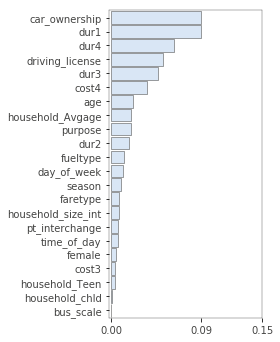

In [20]:
# run the RF model

rf_original, X_train_ori, X_test_ori, y_train_ori, y_test_ori, rf_original_feature_imp = run_rf_XGBoost(X_train2, y_train, params=rf_params)

## RF with SMOTE-NC

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



**** Classification report:
              precision    recall  f1-score   support

           1       0.70      0.82      0.76      2396
           2       0.38      0.33      0.35       386
           3       0.83      0.78      0.81      4776
           4       0.85      0.84      0.84      6134

    accuracy                           0.80     13692
   macro avg       0.69      0.69      0.69     13692
weighted avg       0.80      0.80      0.80     13692


**** Confusion matrix
[[1967   46  153  230]
 [  67  126  106   87]
 [ 338  101 3741  596]
 [ 430   59  490 5155]]

**** Feature importance:


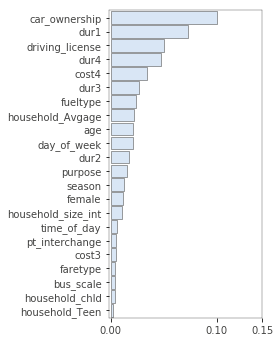

In [21]:
# run the RF model with SMOTENC

# SMOTENC
list_categorical_var = ['household_size_int', 'household_chld', 'household_Teen',
       'household_Avgage', 'car_ownership', 'female', 'age_grp',
       'driving_license', 'purpose', 'fueltype', 'faretype', 'bus_scale',
       'season', 'day_of_week', 'time_of_day']

# creating a mask for categorical_var. The mask consists of TRUE and FALSE
mask_cateogrical_var = [e in list_categorical_var for e in X_train2.columns]

rf_SMOTE, X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE, rf_SMOTE_feature_imp = run_rf_XGBoost(X_train2, y_train, resampling= 'SMOTENC', list_categorical_data=mask_cateogrical_var, params=rf_params)

## RF with ADASYN

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



**** Classification report:
              precision    recall  f1-score   support

           1       0.72      0.80      0.76      2396
           2       0.70      0.27      0.39       386
           3       0.83      0.80      0.81      4776
           4       0.84      0.86      0.85      6134

    accuracy                           0.81     13692
   macro avg       0.77      0.68      0.70     13692
weighted avg       0.81      0.81      0.81     13692


**** Confusion matrix
[[1924   11  178  283]
 [  68  104  125   89]
 [ 316   20 3804  636]
 [ 364   13  486 5271]]

**** Feature importance:


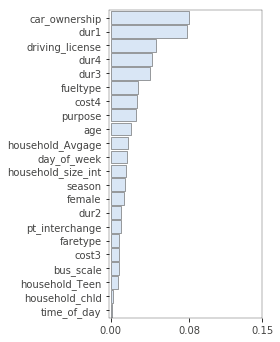

In [22]:
# run the RF model
rf_ADASYN, X_train_ADASYN, X_test_ADASYN, y_train_ADASYN, y_test_ADASYN, rf_ADASYN_feature_imp = run_rf_XGBoost(X_train2, y_train, resampling='ADASYN', params=rf_params)

# Comparing three XGB regarding feature importance

## Plain XGBoost


**** Classification report:
              precision    recall  f1-score   support

           1       0.79      0.76      0.77      2396
           2       0.70      0.15      0.25       386
           3       0.81      0.82      0.82      4776
           4       0.83      0.88      0.86      6134

    accuracy                           0.82     13692
   macro avg       0.78      0.65      0.67     13692
weighted avg       0.81      0.82      0.81     13692


**** Confusion matrix
[[1817   10  228  341]
 [  62   58  159  107]
 [ 226    7 3911  632]
 [ 206    8  503 5417]]

**** Feature importance:


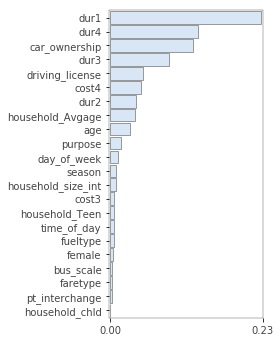

In [23]:
# run the XGBoost model

xgb_original, xgb_X_train_ori, xgb_X_test_ori, xgb_y_train_ori, xgb_y_test_ori, xgb_original_feature_imp = run_rf_XGBoost(X_train2, y_train, params=param_dist, model='XGBoost')

In [23]:
X_test_ori.shape

(13692, 22)

In [24]:
y_test_ori-1

1431     2
39399    2
19129    2
53157    2
31211    3
        ..
1905     0
16683    2
5899     0
22594    3
45372    0
Name: travel_mode, Length: 13692, dtype: int64

## XGBoost with SMOTE-NC

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



**** Classification report:
              precision    recall  f1-score   support

           1       0.75      0.77      0.76      2396
           2       0.44      0.31      0.36       386
           3       0.82      0.81      0.82      4776
           4       0.85      0.86      0.86      6134

    accuracy                           0.81     13692
   macro avg       0.72      0.69      0.70     13692
weighted avg       0.81      0.81      0.81     13692


**** Confusion matrix
[[1853   34  205  304]
 [  57  119  123   87]
 [ 280   73 3872  551]
 [ 270   45  518 5301]]

**** Feature importance:


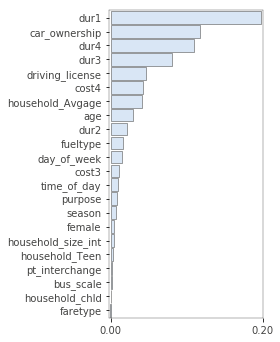

In [24]:
# run the XGBoost model with SMOTENC

# SMOTENC
list_categorical_var = ['household_size_int', 'household_chld', 'household_Teen',
       'household_Avgage', 'car_ownership', 'female', 'age_grp',
       'driving_license', 'purpose', 'fueltype', 'faretype', 'bus_scale',
       'season', 'day_of_week', 'time_of_day']

# creating a mask for categorical_var. The mask consists of TRUE and FALSE
mask_cateogrical_var = [e in list_categorical_var for e in X_train2.columns]

xgb_SMOTE, xgb_X_train_SMOTE, xgb_X_test_SMOTE, xgb_y_train_SMOTE, xgb_y_test_SMOTE, xgb_SMOTE_feature_imp = run_rf_XGBoost(X_train2, y_train, resampling= 'SMOTENC', list_categorical_data=mask_cateogrical_var, params=param_dist, model='XGBoost')

## XGBoost with ADASYN

C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Huanfa Chen\Anaconda3\envs\test_tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)



**** Classification report:
              precision    recall  f1-score   support

           1       0.78      0.78      0.78      2396
           2       0.62      0.25      0.36       386
           3       0.83      0.82      0.82      4776
           4       0.84      0.88      0.86      6134

    accuracy                           0.82     13692
   macro avg       0.77      0.68      0.70     13692
weighted avg       0.82      0.82      0.82     13692


**** Confusion matrix
[[1860   17  199  320]
 [  64   97  133   92]
 [ 249   29 3900  598]
 [ 227   14  479 5414]]

**** Feature importance:


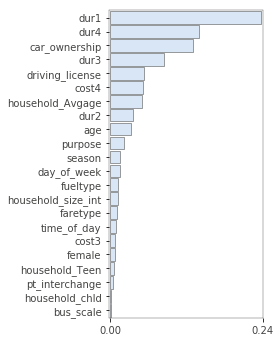

In [25]:
# run the XGBoost model
xgb_ADASYN, xgb_X_train_ADASYN, xgb_X_test_ADASYN, xgb_y_train_ADASYN, xgb_y_test_ADASYN, xgb_ADASYN_feature_imp = run_rf_XGBoost(X_train2, y_train, resampling='ADASYN', params=param_dist, model='XGBoost')

# Plotting feature importance metrics for RF and XGBoost

In [74]:
def plot_feature_importance(df_feature_importance, xmin=None, xmax=None, df_feature_name_mapping=None):
    '''Returns a custom plot object of feature importance.
    
    This function takes a pandas dataframe called df_feature_importance and a dictionary that maps feature names, with the minimum and maximum of the x axis (xmin and xmax).
    
    '''
    fig, ax = plt.subplots(1, figsize=(5,7))
    n_feature = df_feature_importance.shape[0]
    ax.barh(df_feature_importance.index, df_feature_importance['Importance'], height=0.9)
    ax.set_yticks(ticks=np.arange(0,29,1))
    ax.set_yticklabels(labels=df_feature_importance.index, size=16)
    if xmin is None:
        xmin = -0.005
    if xmax is None:
        xmax = df_feature_importance['Importance'].max()
    if df_feature_name_mapping is not None:
        dict_feature_name_mapping = dict(zip(df_feature_name_mapping['existing_name'], df_feature_name_mapping['new_name']))
        df_feature_importance.index = [dict_feature_name_mapping.get(x,x) for x in df_feature_importance.index]
        
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(-0.55, n_feature + 0.5)
    ax.vlines(0,-0.5,n_feature + 0.4, linewidth=1)

    ax.set_xlabel("Decrease in model accuracy",size=18)

    ax.invert_yaxis();
    ax.set_ylabel("Variable",size=18)
#     ax.set_title("Model 4", size=18)
    plt.subplots_adjust(wspace=0.1)

In [75]:
# mapping between existing names and new names
df_feature_name_mapping = pd.DataFrame({'existing_name':['dur1', 'dur2', 'dur3', 'dur4', 'cost3', 'cost4'], 'new_name':['dur_walking', 'dur_cycling', 'dur_pt', 'dur_driving', 'cost_pt', 'cost_driving']})

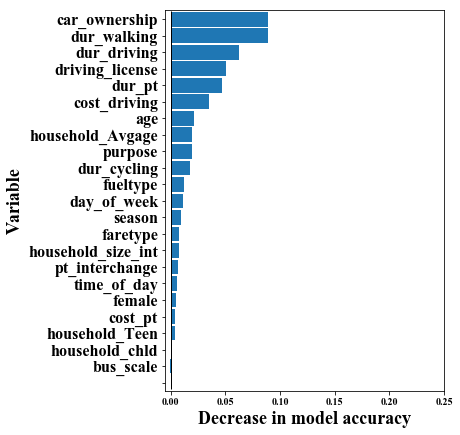

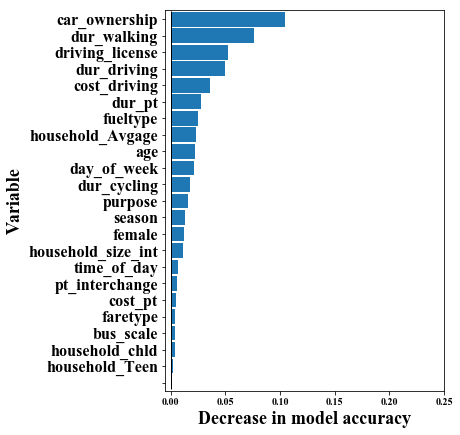

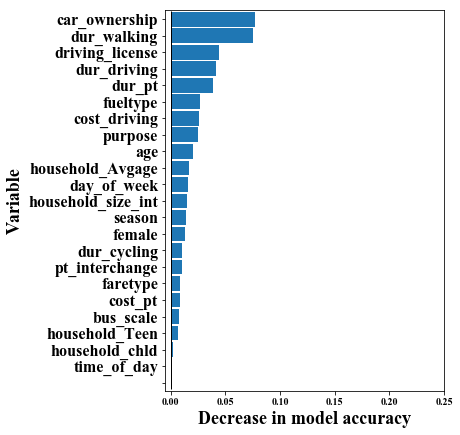

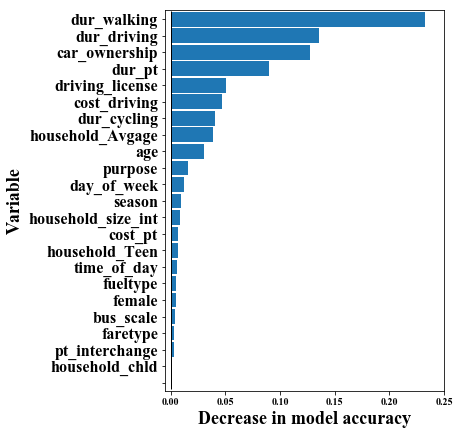

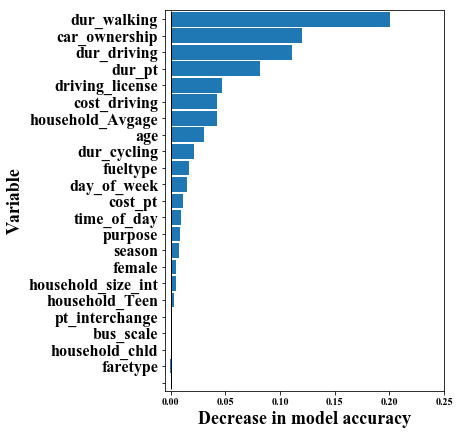

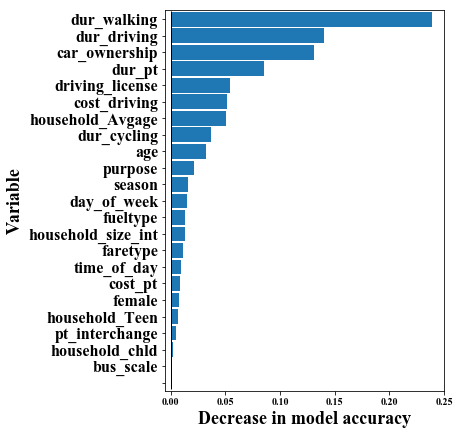

In [76]:
# use a for loop to plot feature importance for six models
dict_model_df_feature_importance = {'RF_Original':rf_original_feature_imp, 'RF_SMOTE': rf_SMOTE_feature_imp, 'RF_ADASYN': rf_ADASYN_feature_imp, 'xgb_original': xgb_original_feature_imp, 'xgb_SMOTE': xgb_SMOTE_feature_imp, 'xgb_ADASYN': xgb_ADASYN_feature_imp}

for (model, df_feature_importance) in dict_model_df_feature_importance.items():
    plot_feature_importance(df_feature_importance=df_feature_importance, df_feature_name_mapping=df_feature_name_mapping, xmax = 0.25)
    plt.savefig('images/feature_importance_' + model + '.tif',bbox_inches='tight',dpi = 300)